* [About this Dataset](#about)
* [EDA](#eda)
* [Data preparation](#dataprep)
* [Modeling](#modeling)
    * [Meta Learners](#metalearners)
        * [T-Learners](#tlearners)
        * [S-Learners](#slearners)
    * [Uplift Trees](#utrees)
* [Conclusions](#conclusions)

# About this Dataset <a class="anchor" id="about"></a>

  The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.  
  
Following is a detailed description of the features:  
  
- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)
- exposure: treatment effect, whether the user has been effectively exposed (binary)

In [3]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.0 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 6.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.2 MB/s eta 0:00:00:00:01
  Created wheel for causalml: filename=causalml-0.15.2-cp37-cp37m-linux_x86_64.whl size=6428246 sha256=6527c8f71a4a679800a4066367ff16b75421e8070af3720aa2a720c8238ab496
  Stored in directory: /root/.cache/pip/wheels/77/7b/df/ae934d53609fe0cd61502f11c72ed039222b98e08cdebe2a06
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=bc60d92b4396578cf49127f86db524f590325bcec2be9b57fea1628d9b21cefc
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built causalml pyd

In [5]:
!pip install scikit-uplift


In [6]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
# from sklift.viz import plot_uplift_preds
# from sklift.models import SoloModel, TwoModels
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

In [8]:
print("helk")

helk


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
def prepare_data(df, feature_cols, treatment_col='treatment', target_col='conversion', 
                 test_size=0.2, random_state=42):
    """
    Prepares data for uplift modeling with binary treatment/control setup
    """
    # Split data into features, treatment and target
    X = df[feature_cols]
    y = df[target_col]
    t = df[treatment_col]

    # Train-test split with stratification on treatment
    X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
        X, t, y, test_size=test_size, random_state=random_state, stratify=t
    )

    return {
        't_train': t_train, 't_test': t_test,'X_train': X_train, 'X_test': X_test,'y_train': y_train, 'y_test': y_test
    }

# Example usage
feature_cols = [f'f{i}' for i in range(12)]
df = pd.read_csv('../input/uplift-modeling/criteo-uplift-v2.1.csv')
data = prepare_data(df, feature_cols)

# Access prepared data
X_train = data['X_train']
X_test = data['X_test']
t_train = data['t_train']
t_test = data['t_test']
y_train = data['y_train']
y_test = data['y_test']


In [32]:
from causalml.inference.meta import BaseSRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


# Initialize and train S-Learner
learner_s = BaseSRegressor(learner=XGBRegressor(random_state=42))
learner_s_result = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

print(learner_s_result)


[[8.54994287e-05]
 [1.00145233e-04]
 [3.63811385e-03]
 ...
 [1.30322325e-04]
 [8.54995669e-05]
 [1.00145233e-04]]


In [33]:
print(learner_s.model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...)


In [ ]:
fitted_model = learner_s.models['slearner']
print(fitted_model.get_booster())  


In [36]:
# This will explicitly fit your S-learner model (XGBoost inside)
learner_s.fit(X=X_train, treatment=t_train, y=y_train)


In [18]:
print(learner_s_result.shape)

(11183673, 1)


In [22]:
result=learner_s.get_importance(X=X_train, tau=learner_s_result, normalize=True, method='auto', features=feature_cols)
result

{1: f4     0.446077
 f3     0.194586
 f11    0.087215
 f9     0.065065
 f0     0.056892
 f2     0.044279
 f10    0.037780
 f6     0.028997
 f8     0.013343
 f5     0.010116
 f7     0.008173
 f1     0.007478
 dtype: float64}

In [43]:
print(learner_s.models)

{1: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)}


In [44]:
print(type(learner_s.model))  # Inspect the type

<class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
fitted_model = learner_s.models['model']



In [46]:
from xgboost import XGBRegressor

# Create your own XGBRegressor
xgb_model = XGBRegressor(random_state=42)

# Create treatment indicator feature
X_augmented = X_train.copy()
X_augmented['treatment'] = t_train

# Fit the model directly on augmented X and original y
xgb_model.fit(X_augmented, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
pip install --upgrade shap


In [ ]:
import shap

# Now this will work as the model is properly fitted
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_augmented)

# Visualize feature impact
shap.summary_plot(shap_values, X_augmented, feature_names=X_augmented.columns)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# Create a per-user SHAP DataFrame
import pandas as pd

shap_df = pd.DataFrame(shap_values, columns=X_augmented.columns)
shap_df['predicted_uplift'] = xgb_model.predict(X_augmented)
shap_df['user_id'] = X_augmented.index

# See the top 5 users
shap_df.head()


In [ ]:
# Top k features driving the prediction per user
shap_df['top_k_features'] = shap_df[X_augmented.columns].abs().apply(
    lambda row: row.nlargest(4).index.tolist(), axis=1
)


In [ ]:
import shap
import pandas as pd

# Step 1: Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Step 2: Compute SHAP values for each user (row) and feature
shap_values = explainer.shap_values(X_augmented)

# Step 3: Convert to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_augmented.columns)

# Step 4: Add predicted uplift as a separate column
shap_df['predicted_uplift'] = xgb_model.predict(X_augmented)

# Step 5: Add unique IDs if not already present
shap_df['user_id'] = X_augmented.index

# Optional: Reorder columns
shap_df = shap_df[['user_id', 'predicted_uplift'] + list(X_augmented.columns)]

# Step 6: View the SHAP contributions for each user
print(shap_df.head())


In [ ]:
import shap

# Use the fitted XGBoost model directly
fitted_model = learner_s.model

# SHAP TreeExplainer
explainer = shap.TreeExplainer(fitted_model)

# Get SHAP values (this gives you the effect of each feature on the model's prediction)
shap_values = explainer.shap_values(X_train)

# Summary plot to visualize feature impact on the treatment effect
shap.summary_plot(shap_values, X_train, feature_names=feature_cols)


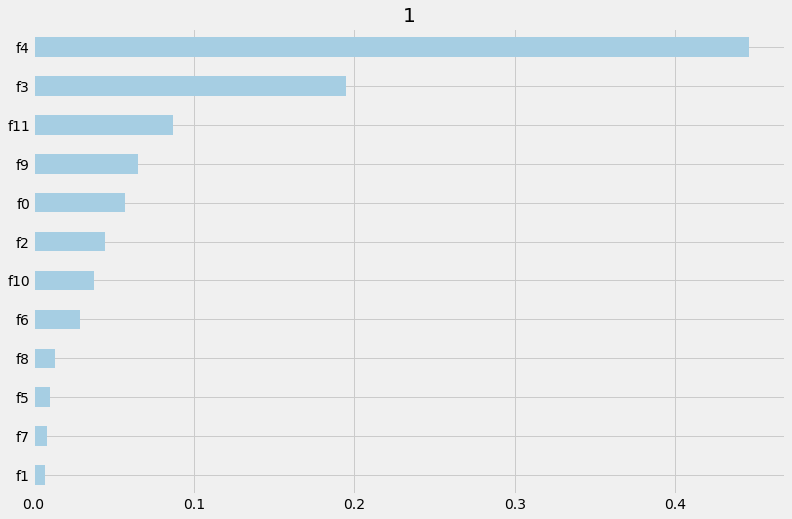

In [29]:
learner_s.plot_importance(X=X_train, tau=learner_s_result, normalize=True, method='auto', features=feature_cols)


In [ ]:
from sklearn.neural_network import MLPRegressor
from causalml.inference.meta import BaseSRegressor

# Define the neural network regressor
nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
                  learning_rate_init=0.01,
                  early_stopping=True,
                  random_state=1)

In [ ]:
from sklearn.neural_network import MLPRegressor
from causalml.inference.meta import BaseSRegressor

# Define your neural network estimator
nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
                  learning_rate_init=0.01,
                  early_stopping=True,
                  random_state=1)

# Plug it into the S-Learner
learner_s = BaseSRegressor(learner=nn)

# Compute ITE estimates for each observation in X_train
nn_ite = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

# Print first few ITE estimates for inspection
print("Estimated ITE via neural network S-Learner:")
print(nn_ite[:5])


In [ ]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from causalml.inference.meta import BaseSRegressor

# # Define the neural network regressor
# nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
#                   learning_rate_init=0.01,
#                   early_stopping=True,
#                   random_state=1)

# # Plug it into the S-Learner
# learner_s = BaseSRegressor(learner=nn)
# learner_s_result = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

# Compute permutation feature importance on the neural network model
# result = permutation_importance(nn, X_train, y_train, n_repeats=10, random_state=42)
result = permutation_importance(learner_s.model, X_train, y_train, n_repeats=10, random_state=42)

result


In [23]:
feature_results = result[1]
feature_results

f4     0.446077
f3     0.194586
f11    0.087215
f9     0.065065
f0     0.056892
f2     0.044279
f10    0.037780
f6     0.028997
f8     0.013343
f5     0.010116
f7     0.008173
f1     0.007478
dtype: float64

In [24]:
feature_results = feature_results/feature_results.sum() * 100
feature_results

f4     44.607747
f3     19.458561
f11     8.721534
f9      6.506494
f0      5.689237
f2      4.427859
f10     3.777985
f6      2.899658
f8      1.334262
f5      1.011587
f7      0.817313
f1      0.747763
dtype: float64

In [25]:
import pickle
# Save the entire model (including its weights) to a checkpoint file
checkpoint_filename = "synapses_checkpint.pkt"
with open(checkpoint_filename, "wb") as f:
    pickle.dump(nn, f)

print(f"Model checkpoint saved to {checkpoint_filename}")

Model checkpoint saved to synapses_checkpint.pkt


In [ ]:
dir(nn)

Looks like the most effective uplift method for this dataset (from tested here) is uplift tree with overall uplift 0.03 (0.031 for top 30%). Among meta learners S-Learners perform better than T-Learners (with a S-Learner based on LGBMClassifier as a leader).